# Introduction


The Diabetes dataset from sklearn is a well-known toy dataset designed specifically for regression tasks. It consists of 10 numerical features representing various medical parameters of diabetes patients and a target variable that indicates a quantitative measure of disease progression after one year.

**Dataset Summary:**
- Total Samples: 442
- Input Features: 10 dimensions of numerical predictive values (e.g., age, sex, BMI, average blood pressure, and six blood serum measurements).
- Target Variable: A quantitative measure of disease progression for diabetes patients one year after baseline.

In this study, we focus on implementing and comparing machine learning models based on regression trees, specifically using the CART (Classification and Regression Trees) algorithm. CART is a foundational algorithm for decision trees and is widely used for both classification and regression tasks. We implement two models in this study:

1. **Single Decision Tree (Without Grid Search):**

 Implemented from scratch using basic decision tree logic and evaluated on the training and testing datasets.
Parameters like 'max_depth' and 'min_samples_split' were tuned manually.

1. **Single Decision Tree (With Grid Search):**

  Implemented from scratch using basic decision tree logic and evaluated on the training and testing datasets.
Parameters like 'max_depth' and 'min_samples_split' were tuned using a grid search.

2. **Random Forest:**

 An ensemble of multiple decision trees built from different bootstrap samples to improve generalization and reduce overfitting.
Performance was compared to a single decision tree to understand the impact of ensemble learning.

**Evaluation Methodology:**
- **Training-Testing Split:** The dataset is split into 80% training and 20% testing, a common approach for small datasets.


*   **Performance Metric:** Mean Squared Error (MSE) was used to evaluate the models' performance, as it is the standard metric for regression tasks.
*   **Parameter Tuning:** For both models, parameters such as max_depth and min_samples_split were tuned to find the optimal configuration.

# Single Decision Tree Implementation


- **Input Variables:** All 10 features of the Diabetes dataset.
- **Target Variable:** Disease progression after one year.
- **Algorithm:** CART (Classification and Regression Trees), specifically designed for regression tasks.
- **Loss Function:** Mean Squared Error (MSE), which measures the average squared difference between the actual and predicted values.
- **Optimisation Algorithm:** Recursive Binary Splitting based on variance reduction.
- **Hyperparameters Tuned:**
 - `max_depth:` 3 (Controls the maximum depth of the tree.)
 - `min_samples_split:` 10 (Minimum number of samples required to split an internal node.)
- **Purpose:** To evaluate the performance of a single decision tree and compare it with ensemble methods like Random Forest.

In [1]:
#---------------- Step 1 Importing Necessary Libraries ----------------

import numpy as np
from sklearn.datasets import load_diabetes

#---------------- Step 2 Load the Dataset ----------------

diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

#---------------- Step 3 Create the Node class for the decision tree ----------------

class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, var_red=None, value=None):
        # Index of the feature used for splitting
        self.feature_index = feature_index

        # Threshold value used to split the node
        self.threshold = threshold

        # Left and right child nodes
        self.left = left
        self.right = right

        # Variance reduction for the split
        self.var_red = var_red

        # Predicted value at the leaf node
        self.value = value

#---------------- Step 4 Create the Decision Tree Regressor class ----------------

class DecisionTreeRegressorScratch:

# Step 4.1: Initialize parameters

    def __init__(self, min_samples_split=2, max_depth=2):
        # Minimum number of samples required to split a node
        self.min_samples_split = min_samples_split

        # Maximum depth of the tree
        self.max_depth = max_depth

        # Root node of the tree
        self.root = None

# Step 4.2: Function to split the dataset based on feature and threshold

    def split(self, dataset, feature_index, threshold):
        """
        Splits the dataset into left and right subsets based on the given feature index and threshold.

        Parameters:
        - dataset: np.array, The dataset to split.
        - feature_index: int, Index of the feature to split on.
        - threshold: float, The threshold value to determine the split.

        Returns:
        - left: np.array, Subset of data where feature values are <= threshold.
        - right: np.array, Subset of data where feature values are > threshold.
        """
        # Split the dataset into left and right based on the feature value and threshold
        left = dataset[dataset[:, feature_index] <= threshold]
        right = dataset[dataset[:, feature_index] > threshold]

        return left, right

# Step 4.3: Function to calculate variance reduction

    def calculate_variance_reduction(self, parent, left, right):
        """
        Calculates the variance reduction for a given split.

        Parameters:
        - parent: np.array, Parent node target values.
        - left: np.array, Left child node target values after the split.
        - right: np.array, Right child node target values after the split.

        Returns:
        - var_reduction: float, The variance reduction value.
        """
        # Calculate the variance of the parent node
        parent_variance = np.var(parent)  # Variance of the parent node

        # Calculate the variance of the left and right child nodes
        left_variance = np.var(left)
        right_variance = np.var(right)

        # Calculate the weighted average of child variances
        n = len(parent)
        n_left, n_right = len(left), len(right)

        # Variance Reduction formula
        var_reduction = parent_variance - ((n_left / n) * left_variance + (n_right / n) * right_variance)

        return var_reduction

# Step 4.4: Function to get the best feature and threshold to split the dataset.

    def get_best_split(self, dataset, num_samples, num_features):
        """
        Find the best feature and threshold to split the dataset.

        Parameters:
        - dataset: np.array, The dataset to find the best split for.
        - num_samples: int, Number of samples in the dataset.
        - num_features: int, Number of features in the dataset.

        Returns:
        - best_split: dict, A dictionary containing the best split information.
        """
        # Initialize the best split as an empty dictionary
        best_split = {"feature_index": None, "threshold": None, "dataset_left": None, "dataset_right": None, "var_red": -float("inf")}

        # Extract the target values (last column) from the dataset
        y = dataset[:, -1]

        # Iterate through each feature
        for feature_index in range(num_features):
            # Get all unique values in the current feature column to use as potential thresholds
            unique_values = np.unique(dataset[:, feature_index])

            # Iterate through each unique value and consider it as a potential threshold
            for threshold in unique_values:
                # Split the dataset based on the current feature and threshold
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)

                # If either left or right dataset is empty, skip this threshold
                if len(dataset_left) == 0 or len(dataset_right) == 0:
                    continue

                # Calculate variance reduction for this split
                curr_var_red = self.calculate_variance_reduction(y, dataset_left[:, -1], dataset_right[:, -1])

                # Update the best split if the current variance reduction is greater than the previous best
                if curr_var_red > best_split["var_red"]:
                    best_split["feature_index"] = feature_index
                    best_split["threshold"] = threshold
                    best_split["dataset_left"] = dataset_left
                    best_split["dataset_right"] = dataset_right
                    best_split["var_red"] = curr_var_red

        return best_split

# Step 4.5: Function to build the decision tree recursively.

    def build_tree(self, dataset, curr_depth=0):
        """
        Recursively builds the decision tree using the CART algorithm.

        Parameters:
        - dataset: np.array, The dataset to build the tree on.
        - curr_depth: int, The current depth of the tree.

        Returns:
        - node: Node object, The root node of the decision tree.
        """
        # Get the number of samples and features (excluding the target column)
        num_samples, num_features = dataset.shape[0], dataset.shape[1] - 1

        # Extract the target values (last column)
        y = dataset[:, -1]

        # Check the stopping conditions
        if num_samples >= self.min_samples_split and curr_depth < self.max_depth:
            # Find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)

            # If a valid split is found, recursively build the left and right subtrees
            if best_split["var_red"] > 0:
                # Create a new decision node
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth + 1)
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth + 1)
                return Node(feature_index=best_split["feature_index"], threshold=best_split["threshold"],
                            left=left_subtree, right=right_subtree, var_red=best_split["var_red"])

        # If stopping condition is met, create a leaf node
        leaf_value = np.mean(y)
        return Node(value=leaf_value)

# Step 4.6: Function to fit the decision tree

    def fit(self, X, y):
        """
        Fits the decision tree regressor to the provided data.

        Parameters:
        - X: np.array, Feature matrix.
        - y: np.array, Target values.

        Returns:
        - self: Fitted decision tree model.
        """
        # Combine X and y into a single dataset
        dataset = np.column_stack((X, y))

        # Build the tree using the combined dataset
        self.root = self.build_tree(dataset)

        # Return the fitted model
        return self

# Step 4.7: Function to make predictions for a single sample.

    def predict_single(self, node, sample):
        """
        Predicts the target value for a single sample by traversing the decision tree.

        Parameters:
        - node: Node object, The root node of the current (sub)tree.
        - sample: np.array, The feature values of the sample to predict.

        Returns:
        - Predicted value stored at the leaf node.
        """
        # Traverse the tree until a leaf node is found
        while node.value is None:
            # Check whether to go to the left or right child node based on the threshold
            if sample[node.feature_index] <= node.threshold:
                node = node.left  # Move to the left child
            else:
                node = node.right  # Move to the right child

        # When a leaf node is reached, return the stored value
        return node.value

# Step 4.8: Function to predict for a batch of samples.

    def predict(self, X):
        """
        Predicts the target values for a batch of samples.

        Parameters:
        - X: np.array, The feature matrix (without target values).

        Returns:
        - predictions: np.array, The predicted values for each sample.
        """
        predictions = [self.predict_single(self.root, sample) for sample in X]
        return np.array(predictions)

#---------------- Step 5 Split data into training and testing sets ----------------

def train_test_split(X, y, test_size=0.2, random_state=None):
    """
    Splits the dataset into training and testing sets.

    Parameters:
    - X: np.array, Feature matrix.
    - y: np.array, Target vector.
    - test_size: float, The proportion of the dataset to include in the test split (default: 0.2).
    - random_state: int, Seed value for random number generator (default: None).

    Returns:
    - X_train: np.array, Training feature set.
    - X_test: np.array, Testing feature set.
    - y_train: np.array, Training target set.
    - y_test: np.array, Testing target set.
    """
    # Ensure reproducibility if random_state is specified
    if random_state is not None:
        np.random.seed(random_state)

    # Get the total number of samples
    num_samples = len(X)

    # Create a random permutation of indices
    indices = np.random.permutation(num_samples)

    # Determine the number of test samples
    num_test_samples = int(test_size * num_samples)

    # Get the indices for testing and training
    test_indices = indices[:num_test_samples]
    train_indices = indices[num_test_samples:]

    # Split the feature matrix and target vector into training and testing sets
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

# Split the data using the newly defined function
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#---------------- Step 6 Train and Evaluate the Decision Tree Model ----------------

# Step 6.1: Fit the Decision Tree Model on the Training Data

tree_regressor = DecisionTreeRegressorScratch(min_samples_split=10, max_depth=3)
tree_regressor.fit(X_train, y_train)

# Step 6.2: Make Predictions on the Testing and Training Data

y_train_pred = tree_regressor.predict(X_train)
y_test_pred = tree_regressor.predict(X_test)

# Step 6.3: Implement Mean Squared Error (MSE)

def mean_squared_error_scratch(y_true, y_pred):
    """
    Calculate Mean Squared Error (MSE) from scratch.

    Parameters:
    - y_true: np.array, Actual target values.
    - y_pred: np.array, Predicted target values.

    Returns:
    - mse: float, The Mean Squared Error.
    """
    n = len(y_true)  # Number of samples
    squared_errors = [(y_true[i] - y_pred[i]) ** 2 for i in range(n)]  # List of squared differences
    mse = sum(squared_errors) / n  # Calculate the mean of the squared errors
    return mse

# Step 6.4: Calculate and Display MSE on Testing Data and Training Data
mse_train = mean_squared_error_scratch(y_train, y_train_pred)
mse_test = mean_squared_error_scratch(y_test, y_test_pred)

# Display the Mean Squared Error
print(f"Mean Squared Error on the Training Set: {mse_train:.4f}")
print(f"Mean Squared Error on the Testing Set: {mse_test:.4f}")



Mean Squared Error on the Training Set: 2926.9362
Mean Squared Error on the Testing Set: 3697.6324


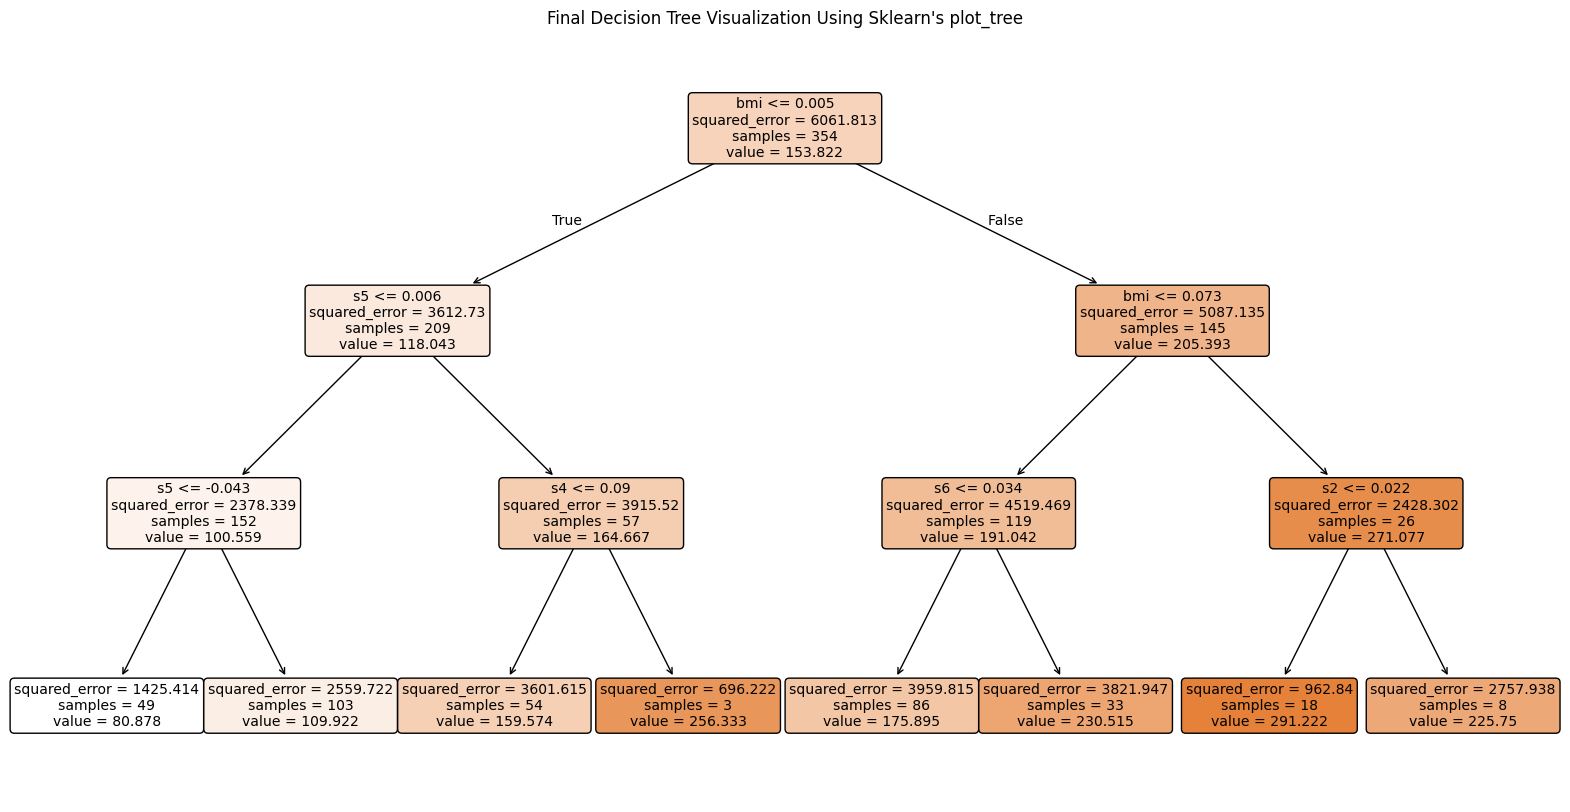

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# Visualize the Final Decision Tree Using Built-in Tools

# Retrain a decision tree using the optimal parameters (e.g., min_samples_split=10, max_depth=3)
sklearn_tree = DecisionTreeRegressor(max_depth=3, min_samples_split=10, random_state=42)
sklearn_tree.fit(X_train, y_train)

# Plot the decision tree using built-in plot_tree function
plt.figure(figsize=(20, 10))  # Set the figure size
plot_tree(sklearn_tree, feature_names=diabetes.feature_names, filled=True, rounded=True)
plt.title("Final Decision Tree Visualization Using Sklearn's plot_tree")
plt.show()


# Final Decision Tree with Grid Search

- **Input Variables:** All 10 features of the Diabetes dataset.
- **Target Variable:** Disease progression after one year.
- **Algorithm:** CART (Classification and Regression Trees), specifically designed for regression tasks.
- **Loss Function:** Mean Squared Error (MSE), which measures the average squared difference between the actual and predicted values.
- **Optimisation Algorithm:** Recursive Binary Splitting based on variance reduction.
- **Hyperparameter Tuning:**
 - `max_depth` and `min_samples_split` were tuned using a **Grid Search** to find the optimal configuration.
- **Optimal Hyperparameters:**
 - `max_depth:` 5
 - `min_samples_split:` 15
- **Purpose:** To select the best configuration of the Decision Tree model using Grid Search, ensuring the model has the best trade-off between bias and variance for better generalization on unseen data.


In [2]:
#---------------- Step 7 Implement Grid Search for Hyperparameter Tuning ----------------

# Define the range of values for min_samples_split and max_depth
min_samples_split_values = [2, 5, 10, 15]  # Possible values for min_samples_split
max_depth_values = [2, 3, 4, 5, 6]  # Possible values for max_depth

# Initialize variables to store the best parameters and lowest MSE
best_params = {"min_samples_split": None, "max_depth": None}
lowest_mse = float("inf")

# Perform a grid search by iterating through all combinations of parameters
for min_samples_split in min_samples_split_values:
    for max_depth in max_depth_values:
        # Create a new decision tree regressor with the current parameters
        tree_regressor = DecisionTreeRegressorScratch(min_samples_split=min_samples_split, max_depth=max_depth)

        # Fit the model on the training data
        tree_regressor.fit(X_train, y_train)

        # Predict on the testing data
        y_pred = tree_regressor.predict(X_test)

        # Calculate the MSE on the testing data
        curr_mse = mean_squared_error_scratch(y_test, y_pred)

        # Print the parameters and corresponding MSE for tracking
        print(f"min_samples_split: {min_samples_split}, max_depth: {max_depth}, Test MSE: {curr_mse:.4f}")

        # Update the best parameters if current MSE is lower than the lowest recorded MSE
        if curr_mse < lowest_mse:
            lowest_mse = curr_mse
            best_params["min_samples_split"] = min_samples_split
            best_params["max_depth"] = max_depth

# Display the best parameters and lowest MSE found during grid search
print("\nBest Parameters Found:")
print(f"min_samples_split: {best_params['min_samples_split']}, max_depth: {best_params['max_depth']}")
print(f"Lowest Test MSE: {lowest_mse:.4f}")


min_samples_split: 2, max_depth: 2, Test MSE: 3908.9483
min_samples_split: 2, max_depth: 3, Test MSE: 3697.6324
min_samples_split: 2, max_depth: 4, Test MSE: 3749.2856
min_samples_split: 2, max_depth: 5, Test MSE: 3899.8339
min_samples_split: 2, max_depth: 6, Test MSE: 4022.7929
min_samples_split: 5, max_depth: 2, Test MSE: 3908.9483
min_samples_split: 5, max_depth: 3, Test MSE: 3697.6324
min_samples_split: 5, max_depth: 4, Test MSE: 3734.8973
min_samples_split: 5, max_depth: 5, Test MSE: 3801.4996
min_samples_split: 5, max_depth: 6, Test MSE: 4006.0328
min_samples_split: 10, max_depth: 2, Test MSE: 3908.9483
min_samples_split: 10, max_depth: 3, Test MSE: 3697.6324
min_samples_split: 10, max_depth: 4, Test MSE: 3506.0763
min_samples_split: 10, max_depth: 5, Test MSE: 3492.8916
min_samples_split: 10, max_depth: 6, Test MSE: 3667.4160
min_samples_split: 15, max_depth: 2, Test MSE: 3908.9483
min_samples_split: 15, max_depth: 3, Test MSE: 3697.6324
min_samples_split: 15, max_depth: 4, Test

In [4]:
#---------------- Step 8 Final Model Training and Evaluation ----------------

# Create a new decision tree regressor using the best parameters
final_tree_regressor = DecisionTreeRegressorScratch(min_samples_split=15, max_depth=5)

# Fit the final model on the training data
final_tree_regressor.fit(X_train, y_train)

# Predict on the training data to calculate Training MSE
y_train_pred_final = final_tree_regressor.predict(X_train)
final_train_mse = mean_squared_error_scratch(y_train, y_train_pred_final)

# Predict on the testing data to calculate Testing MSE
y_test_pred_final = final_tree_regressor.predict(X_test)
final_test_mse = mean_squared_error_scratch(y_test, y_test_pred_final)

# Display the final Training and Testing MSE
print(f"Final Training MSE: {final_train_mse:.4f}")
print(f"Final Testing MSE: {final_test_mse:.4f}")

# Analyze if there is overfitting or underfitting
if final_train_mse < final_test_mse:
    print("The model is likely overfitting, as Training MSE is lower than Testing MSE.")
elif final_train_mse > final_test_mse:
    print("The model is likely underfitting, as Training MSE is higher than Testing MSE.")
else:
    print("The model has similar performance on both Training and Testing sets.")


Final Training MSE: 2113.1516
Final Testing MSE: 3415.7669
The model is likely overfitting, as Training MSE is lower than Testing MSE.


# Random Forest Implementation


- **Input Variables:** All 10 features of the Diabetes dataset.
- **Target Variable:** Disease progression after one year.
- **Algorithm:** An ensemble of multiple Decision Trees (using the CART algorithm) built using bootstrap sampling and random feature selection.
- **Ensemble Method:** Bagging (Bootstrap Aggregating) to create multiple diverse trees, each trained on different subsets of the data.
- **Loss Function:** Mean Squared Error (MSE), which measures the average squared difference between the actual and predicted values.
- **Aggregation Method:** Averaging the predictions from all trees in the forest.
- **Hyperparameters Tuned:**
 - `n_estimators:` Number of trees in the forest.
 - `max_depth:` Controls the maximum depth of each tree.
 - `min_samples_split:` Minimum number of samples required to split an internal node.
- **Purpose:** To improve the generalization and robustness of a single decision tree by reducing overfitting through ensembling.

In [5]:
#---------------- Step 9 Implementing Random Forest from Scratch ----------------

class RandomForestRegressorScratch:
    def __init__(self, n_estimators=10, min_samples_split=2, max_depth=3, random_state=None):
        """
        Initialize the Random Forest with given parameters.

        Parameters:
        - n_estimators: int, Number of trees in the forest.
        - min_samples_split: int, Minimum number of samples required to split a node.
        - max_depth: int, Maximum depth of each tree.
        - random_state: int, Seed for reproducibility (default: None).
        """
        self.n_estimators = n_estimators
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []

    def fit(self, X, y):
        """
        Fit the Random Forest model on the given training data.

        Parameters:
        - X: np.array, Feature matrix.
        - y: np.array, Target values.
        """
        # Set the random state for reproducibility
        if self.random_state:
            np.random.seed(self.random_state)

        # Build multiple decision trees
        for _ in range(self.n_estimators):
            # Create a bootstrap sample of the data
            bootstrap_indices = np.random.choice(np.arange(len(X)), size=len(X), replace=True)
            X_bootstrap = X[bootstrap_indices]
            y_bootstrap = y[bootstrap_indices]

            # Create a new decision tree with the specified parameters
            tree = DecisionTreeRegressorScratch(min_samples_split=self.min_samples_split, max_depth=self.max_depth)

            # Fit the tree on the bootstrap sample
            tree.fit(X_bootstrap, y_bootstrap)

            # Store the fitted tree
            self.trees.append(tree)

    def predict(self, X):
        """
        Predict the target values for the given input data using the Random Forest.

        Parameters:
        - X: np.array, Feature matrix.

        Returns:
        - predictions: np.array, Averaged predictions from all trees.
        """
        # Get predictions from each tree
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])

        # Average the predictions across all trees
        return np.mean(tree_predictions, axis=0)

#---------------- Step 10 Train and Evaluate the Random Forest Model ----------------

# Create the Random Forest with 10 trees, max depth of 5, and min_samples_split of 15
random_forest_regressor = RandomForestRegressorScratch(n_estimators=10, min_samples_split=15, max_depth=5, random_state=42)

# Fit the Random Forest on the training data
random_forest_regressor.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred_rf = random_forest_regressor.predict(X_train)

# Make predictions on the testing data
y_test_pred_rf = random_forest_regressor.predict(X_test)

# Calculate Training and Testing MSE using our custom MSE function
train_mse_rf = mean_squared_error_scratch(y_train, y_train_pred_rf)
test_mse_rf = mean_squared_error_scratch(y_test, y_test_pred_rf)

# Display the Training and Testing MSE
print(f"Random Forest Training MSE: {train_mse_rf:.4f}")
print(f"Random Forest Testing MSE: {test_mse_rf:.4f}")

# Compare with the single decision tree performance
print("\nPerformance Comparison:")
print(f"Single Decision Tree Training MSE: {final_train_mse:.4f}")
print(f"Single Decision Tree Testing MSE: {final_test_mse:.4f}")


Random Forest Training MSE: 1869.4872
Random Forest Testing MSE: 2911.4880

Performance Comparison:
Single Decision Tree Training MSE: 2113.1516
Single Decision Tree Testing MSE: 3415.7669


# Final Findings

MSE Scores:
- Initial Single Decision Tree (Without Grid Search) = **3697.6324**
- Final Single Decision Tree (With Grid Search) = **3415.7669**
- Random Forest = **2911.4880**

The Random Forest outperformed both the initial and final Single Decision Trees by reducing overfitting and improving generalization to unseen data. The final decision tree, after hyperparameter tuning using Grid Search, showed slight improvement over the initial tree, but the Random Forest provided the best performance overall. This result indicates that using an ensemble method like Random Forest can significantly enhance the model's performance by averaging multiple decision trees, making the predictions more stable and less sensitive to the training data. For future projects, experimenting with other ensemble techniques such as Gradient Boosting or fine-tuning the parameters further could yield even better results.
